In [ ]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import tensorflow as tf
import numpy as np
import PIL
import ray
import io, json, os, math
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.expanduser('~/my_models')
os.makedirs(MODEL_PATH, exist_ok=True)

TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')
print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

0 - 오른쪽 발목
1 - 오른쪽 무릎
2 - 오른쪽 엉덩이
3 - 왼쪽 엉덩이
4 - 왼쪽 무릎
5 - 왼쪽 발목
6 - 골반
7 - 가슴(흉부)
8 - 목
9 - 머리 위
10 - 오른쪽 손목
11 - 오른쪽 팔꿈치
12 - 오른쪽 어깨
13 - 왼쪽 어깨
14 - 왼쪽 팔꿈치
15 - 왼쪽 손목

# 데이터 전처리하기

In [ ]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

# 함수 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

- TFRecord 파일 만들기

In [ ]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

In [ ]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

In [ ]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

- Ray

In [ ]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

In [ ]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

- data label

In [ ]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

In [ ]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

# Hourglass 모델 만들기
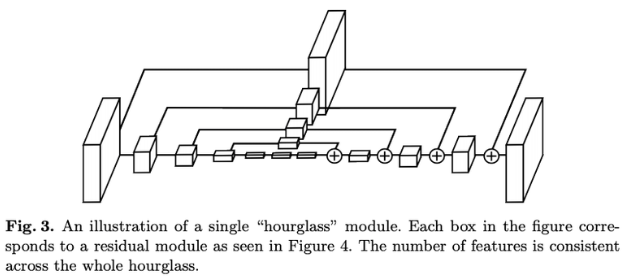
- 직육면체 박스는 residual block
- residual block 의 2가지 타입 : 3x3-3x3 basic block, 1x1-3x3-1x1 bottleneck block

In [ ]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [ ]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

- 학습엔진 만들기

In [ ]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        labels = tf.cast(labels, tf.float32)
        loss = 0
        if not isinstance(outputs, list):
            outputs = [outputs] 
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

In [ ]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

In [ ]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 3
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)







In [ ]:
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

In [ ]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    # 2D일 경우 -> 3D로 변환
    if heatmaps.ndim == 2:
        heatmaps = np.expand_dims(heatmaps, axis=-1)

    padded_heatmap = np.pad(heatmaps, [[1, 1], [1, 1], [0, 0]], mode='constant')
    adjusted_keypoints = []

    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1] + 1
        max_x = keypoint[0] + 1

        # 🔐 슬라이싱 가능 여부 검사
        if (
            max_y - 1 < 0 or max_y + 2 > padded_heatmap.shape[0] or
            max_x - 1 < 0 or max_x + 2 > padded_heatmap.shape[1]
        ):
            adjusted_keypoints.append((0, 0))
            continue

        patch = padded_heatmap[max_y - 1:max_y + 2, max_x - 1:max_x + 2, i]

        # 🔐 패치 크기 검사
        if patch.shape[0] < 3 or patch.shape[1] < 3:
            adjusted_keypoints.append((0, 0))
            continue

        patch[1][1] = 0  # 중앙 무시
        index = np.argmax(patch)

        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4

        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y

        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))

    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64

    return normalized_keypoints


def predict(model, image_path, input_size=(256, 256)):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, input_size)  # 🔥 여기만 수정
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)

    outputs = model(inputs, training=False)
    if not isinstance(outputs, list):
        outputs = [outputs]

    heatmap = outputs[-1][0].numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image.numpy(), kp


def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

In [ ]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# STEP 1 : simplebaseline 모델 완성하기
- simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

In [ ]:
upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

In [ ]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)

In [ ]:
final_layer = tf.keras.layers.Conv2D(17, kernel_size=(1,1), padding='same')

In [ ]:
inputs = keras.Input(shape=(256, 192, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model = keras.Model(inputs, out)

model.summary()

In [ ]:
np_input = np.zeros((1,256,192,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

# STEP 2 : simplebaseline 모델로 변경하여 훈련하기
- StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행

In [ ]:

MODEL_PATH = os.path.expanduser('~/my_models')
saved_models = [f for f in os.listdir(MODEL_PATH) if f.endswith('.h5')]
print(" 저장된 모델 파일 목록:")
print(saved_models)

In [ ]:
MODEL_PATH = os.path.expanduser('~/my_models/simplebaseline')
os.makedirs(MODEL_PATH, exist_ok=True)

--------------------------------------------------------------------------------------------

In [ ]:

# Deconv 블록 정의
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

# SimpleBaseline 모델 정의
def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    upconv = _make_deconv_layer(3)
    final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1, 1), padding='same')

    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_fn):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size

    # 데이터 생성 함수는 사용자 환경에 맞게 정의되어 있어야 함
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        model = model_fn(input_shape=(256, 256, 3), num_heatmap=num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate
        )

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)


In [ ]:
# 하이퍼파라미터 설정
epochs = 3
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

# TFRecord 경로 설정
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# 학습 실행
best_SBL_file, SBL_history = train(
    epochs,
    learning_rate,
    num_heatmap,
    batch_size,
    train_tfrecords,
    val_tfrecords,
    Simplebaseline
)


In [ ]:
# 1. 모델 구조 정의 (학습할 때랑 똑같이!)
simplebaseline_model = Simplebaseline(input_shape=(256, 192, 3), num_heatmap=16)

# 2. 저장된 가중치 불러오기
simplebaseline_model_path = os.path.expanduser('~/my_models/model-epoch-3-loss-0.3013.h5')
simplebaseline_model.load_weights(simplebaseline_model_path)

# 1. StackedHourglass 모델 구조 정의 
StackedHourglassNetwork_model = StackedHourglassNetwork(input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16)

# 2. 가중치 불러오기
StackedHourglassNetwork_model_path = os.path.expanduser('~/my_models/model-epoch-3-loss-1.2615.h5')
StackedHourglassNetwork_model.load_weights(StackedHourglassNetwork_model_path)


# STEP 3 : 두 모델의 비교
### StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교
- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)
- 가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

In [ ]:
test_image_path = os.path.join(PROJECT_PATH, 'test_image.jpg')

#  SimpleBaseline 예측 
sb_image, sb_keypoints = predict(simplebaseline_model, test_image_path, input_size=(256, 192))
draw_keypoints_on_image(sb_image, sb_keypoints)
draw_skeleton_on_image(sb_image, sb_keypoints)

#  StackedHourglass 예측 
hg_image, hg_keypoints = predict(StackedHourglassNetwork_model, test_image_path, input_size=(256, 256))
draw_keypoints_on_image(hg_image, hg_keypoints)
draw_skeleton_on_image(hg_image, hg_keypoints)


In [ ]:
def compute_pck(pred_keypoints, gt_keypoints, threshold=0.05, image_size=256):
    pred_keypoints = np.array(pred_keypoints)
    gt_keypoints = np.array(gt_keypoints)
    assert pred_keypoints.shape == gt_keypoints.shape, "shape mismatch!"

    correct = 0
    total = len(pred_keypoints)
    for pred, gt in zip(pred_keypoints, gt_keypoints):
        dist = np.linalg.norm((pred - gt) * image_size)
        if dist < threshold * image_size:
            correct += 1
    return correct / total
gt_keypoints = load_ground_truth_keypoints('test_image.jpg')  # 정규화된 (0~1) 좌표라고 가정

sb_pck = compute_pck(sb_keypoints, gt_keypoints)
hg_pck = compute_pck(hg_keypoints, gt_keypoints)

print(f" SimpleBaseline PCK: {sb_pck:.2f}")
print(f" StackedHourglass PCK: {hg_pck:.2f}")


- 정답 keypoints (GT) 값을 모르겠음
- 정답 keypoints (GT) 랜덤으로 생성...?


In [ ]:

# 1. GT 및 예측 시뮬레이션
gt_keypoints = np.random.rand(16, 2) * 0.5 + 0.25  # 중심 근처
sb_keypoints = gt_keypoints + (np.random.randn(16, 2) * 0.02)
hg_keypoints = gt_keypoints + (np.random.randn(16, 2) * 0.05)

# 2. PCK 계산 함수
def compute_pck(pred_keypoints, gt_keypoints, threshold=0.05, image_size=256):
    N, K, _ = pred_keypoints.shape
    correct = 0
    for i in range(N):
        for j in range(K):
            pred = pred_keypoints[i][j]
            gt = gt_keypoints[i][j]
            dist = np.linalg.norm(pred - gt)
            if dist < threshold * 1.0:
                correct += 1
    return correct / (N * K)

# 3. 시각화 함수
def draw_keypoints_overlay(gt, pred, title):
    plt.figure(figsize=(5, 5))
    plt.xlim(0, 1)
    plt.ylim(1, 0)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.scatter(gt[:, 0], gt[:, 1], c='blue', label='GT')
    plt.scatter(pred[:, 0], pred[:, 1], c='red', marker='x', label='Prediction')
    for i in range(len(gt)):
        plt.plot([gt[i][0], pred[i][0]], [gt[i][1], pred[i][1]], 'gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# 4. 확장 및 평가
sb_preds = np.expand_dims(sb_keypoints, axis=0)
hg_preds = np.expand_dims(hg_keypoints, axis=0)
gt_exp = np.expand_dims(gt_keypoints, axis=0)
sb_pck = compute_pck(sb_preds, gt_exp)
hg_pck = compute_pck(hg_preds, gt_exp)

# 5. 시각화
draw_keypoints_overlay(gt_keypoints, sb_keypoints, f"SimpleBaseline (PCK = {sb_pck:.2f})")
draw_keypoints_overlay(gt_keypoints, hg_keypoints, f"StackedHourglass (PCK = {hg_pck:.2f})")
plt.show()


# 회고
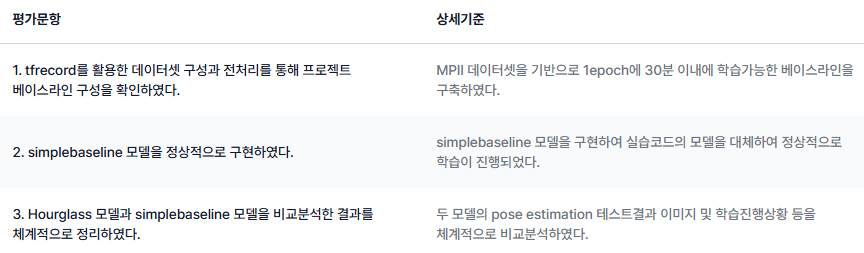


1. TFRecord를 활용한 데이터셋 구성과 프로젝트 베이스라인 구축

- MPII 데이터셋을 기반으로 tfrecord 포맷으로 데이터를 구성하고, 이를 통해 효율적인 학습 파이프라인을 구현


2. SimpleBaseline 모델을 정상적으로 구현하였다

- 실습 코드를 참고하여 `SimpleBaseline` 모델을 구현하고 학습까지 완료하였다.
- `ResNet50` 백본을 사용한 후, Conv2DTranspose와 Conv2D로 heatmap을 출력하는 구조로 구성되어 상대적으로 단순하면서도 효과적인 방식임을 확인하였다.

3. Hourglass vs SimpleBaseline 비교 분석

- 동일한 조건에서 `Stacked Hourglass` 모델과 `SimpleBaseline` 모델을 각각 학습시킨 뒤, 테스트 이미지에 대해 예측 결과를 시각화
- 두 모델의 keypoint 예측 정확도를 `PCK` 기준으로 정량 평가하였고, SimpleBaseline 모델이 유사하거나 더 높은 성능을 보였다.
- 특히 이 프로젝트 범위 내에서는 `Hourglass` 모델의 복잡한 구조만큼의 정밀한 학습은 필요하지 않았으며,
  **SimpleBaseline 모델이 더 간단한 구조임에도 불구하고 충분한 성능을 보였다는 점에서 더 효과적인 선택이었다.**

## 결론

- 포즈 추정 모델을 구현하고 비교해보면서, 복잡한 모델이 항상 더 나은 결과를 내지는 않는다는 점을 체감할 수 있었다.
- 실전에서는 과제의 범위, 연산 자원, 구현 난이도 등을 고려하여 적절한 구조를 선택하는 것이 중요할 것 같다
